# CNTK 101: Logistic Regression 


## Introduction

**Problem**: determine to what type of iris each unseen example belongs to. This is known as a **classification** problem. 

<img src="https://cdn-images-1.medium.com/max/800/0*gMrEyZgDJ_nIUcao." >

**Goal**: learn a classifier that can automatically label any iris sample into one of the three categories given it's features.

**Approach**: Any learning algorithm typically has 3 stages:

>1. Extracting & preprocessing the data.
>2. Creating & learning the model. 
>3. Prediction & evaluation.

## Logistic Regression
[Logistic regression][] is a ML technique that uses a linear weighted combination of features and generates the probability of predicting different classes. The resulting sum is mapped to a (0, 1) range via a [sigmoid][] function. For classifiers with more than two output labels, one can use a [softmax][] function.
[sigmoid]: https://en.wikipedia.org/wiki/Sigmoid_function
[softmax]: https://en.wikipedia.org/wiki/Softmax_function
[logistic regression]: https://en.wikipedia.org/wiki/Logistic_regression

<img src="https://rasbt.github.io/mlxtend/user_guide/classifier/SoftmaxRegression_files/logistic_regression_schematic.png" width="500px">
<img src="https://qph.ec.quoracdn.net/main-qimg-7c9b7670c90b286160a88cb599d1b733" width="400px">

## Get the data 

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import required libraries
import Regression
import numpy as np

In [2]:
#import lib with needed data
from sklearn import datasets

iris = datasets.load_iris()
train_features, train_labels, test_features, test_labels = Regression.transform_data(iris.data, iris.target)

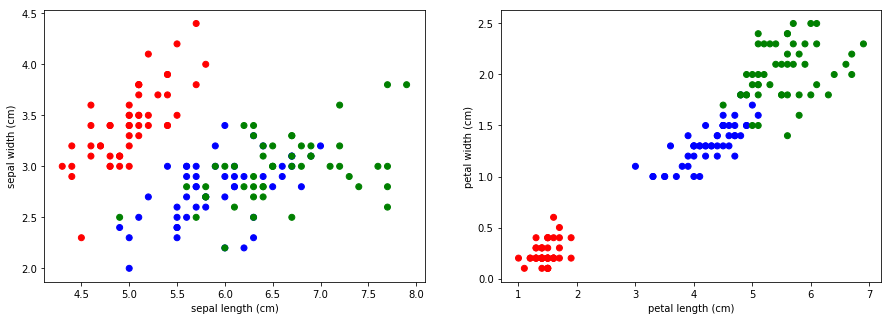

In [3]:
#Visualization of the input data.
Regression.draw_iris(iris)

Because we want to visualize our dicision boundary later, let's use just 2 features: sepal length and width

In [4]:
train_features, test_features = train_features[:,[2,3]], test_features[:,[2,3]]

## Model Creation

<img src="http://www.cntk.ai/jup/cntk103b_TwoFormsOfLR-v3.png" width="300px">

Calculate the sum:

$$z = \sum_{i=1}^n w_i \times x_i + b = \textbf{w} \cdot \textbf{x} + b$$ 

where $\bf{w}$ is the weight vector of length $n$ and $b$ is known as the [bias][] term. 

The computed sum is mapped to a (0, 1) range using a `sigmoid` (when the outcome can be in one of two possible classes) or a `softmax` function (when the outcome can be in one of more than two possible classes).

[bias]: https://www.quora.com/What-does-the-bias-term-represent-in-logistic-regression

In [5]:
import cntk as C

In [6]:
def linear_sum(input_var, output_dim):

    weight_param, bias_param = Regression.create_params(input_var, output_dim)
    
    return C.times(input_var, weight_param) + bias_param

The `linear_sum` function performs two operations:
0. multiply the weights ($\bf{w}$)  with the features ($\bf{x}$) using the CNTK `times` operator,
1. add the bias term ($b$).

In [7]:
# Define the data dimensionality & input variable
output_dim = len(iris.target_names)
input_var  = C.input_variable(train_features.shape[1], np.float32)

z = linear_sum(input_var, output_dim)


The output of the `softmax` is the probability. 
For training the classifier, we need to minimize the difference between the **h** (mapped output) and the **y** (ground-truth) labels.
The most common way to measure the difference is the **cross-entropy**:

$$ \mathrm{softmax}(x)=\left[\frac{\exp(x_1)}{\sum_i\exp(x_i)}\quad\frac{\exp(x_1)}{\sum_i\exp(x_i)}\quad\ldots\quad\frac{\exp(x_1)}{\sum_i\exp(x_i)}\right] $$
$$ $$
$$ \mathrm{h} = \mathrm{softmax}(z)$$ 
$$  J(h) = - \sum_{j=1}^{n} y_j \log (h_j) $$


In [8]:
#setup ground-truth value
label = C.input_variable(output_dim, np.float32)

#define cost (difference between the h and the y)
cost = C.cross_entropy_with_softmax(z, label)

#estimate the predicted label using classification error function
eval_error = C.classification_error(z, label, axis=0)

#setup teaching workflow
learner = Regression.create_learner(z)

#instantiate the trainer to drive the model training
trainer = C.Trainer(z, (cost, eval_error), [learner])

## Training

In [9]:
from collections import defaultdict

epochs = 600
training_progress_output_freq = 60

plotdata = defaultdict(list)

for i in range(1, epochs+1):
    
    # Assign the data to the input variables and train the model
    trainer.train_minibatch({input_var : train_features, label : train_labels})
    
    #update information about training progress
    plotdata = Regression.update_training_progress(trainer, i, training_progress_output_freq, plotdata)
        

Epoch: 60, Loss: 1.7074, Error: 0.34
Epoch: 120, Loss: 1.4599, Error: 0.34
Epoch: 180, Loss: 1.2426, Error: 0.34
Epoch: 240, Loss: 1.0365, Error: 0.34
Epoch: 300, Loss: 0.8457, Error: 0.31
Epoch: 360, Loss: 0.6757, Error: 0.30
Epoch: 420, Loss: 0.5302, Error: 0.27
Epoch: 480, Loss: 0.4110, Error: 0.16
Epoch: 540, Loss: 0.3178, Error: 0.17
Epoch: 600, Loss: 0.2492, Error: 0.12


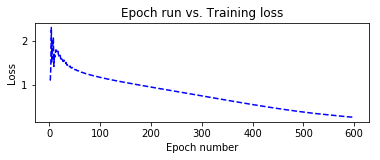

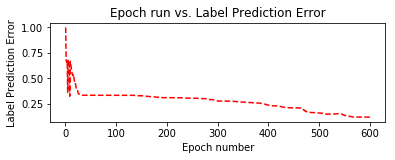

In [10]:
Regression.plot_learning_process(plotdata)

## Evaluation

Evaluation the trained model on data that hasn't been used for training is called **testing**.

In [11]:
# Run the trained model on test data
test_error = trainer.test_minibatch({input_var : test_features, label : test_labels}) 
print('Testing error:', test_error)

Testing error: 0.044444444444444446


**Checking the prediction.** We can compare the ground-truth label with the our predictions.  

In [18]:
out = C.softmax(z)
result = out.eval({input_var : test_features})

print("Label    :", [np.argmax(label) for label in test_labels[:30]])
print("Predicted:", [np.argmax(x) for x in result[:30]])

Label    : [2, 2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 2, 0, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 2, 0]
Predicted: [2, 2, 1, 1, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 2, 0, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 2, 0]


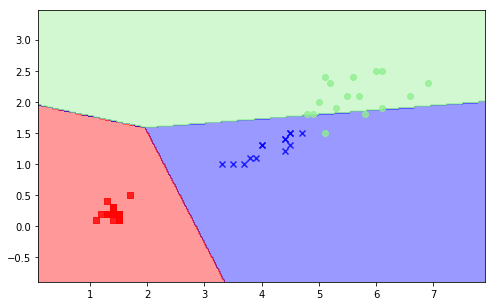

In [13]:
#Visualize the decision boundaries
Regression.plot_decision_regions(test_features, test_labels, out)